# Estimating Probabilites with Bayesian Inference

Today's Bayesian problem of the week: Suppose we visit a wild animal preserve where we know that the only animals are lions and tigers and bears, but we don't know how many of each there are. During the tour, we see 3 lions, 2 tigers, and 1 bear. Assuming that every animal had an equal chance to appear in our sample, estimate the prevalence of each species. What is the probability that the next animal we see is a bear?

In [5]:
import pandas as pd
import numpy as np

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 22
%matplotlib inline

from matplotlib import MatplotlibDeprecationWarning

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=MatplotlibDeprecationWarning)

import pymc3 as pm

# Helper functions
# from utils import draw_pdf_contours, Dirichlet, plot_points, annotate_plot, add_legend, display_probs

# Model

The overall system is as follows (each part will be explained):

The underlying model is a multinomial distribution with parameters $p_k$
The prior distribution of $p_k$ is a Dirichlet Distribution
The $\alpha$ vector is a parameter of the prior Dirichlet Distribution, hence a hyperparameter
A Multinomial Distribution with a Dirichlet Prior is referred to as a Dirichlet-Multinomial Distribution.

Our model can be expressed in equations as:

$${\begin{array}{lclcl}{\boldsymbol {\alpha }}&amp;=&amp;(\alpha _{1},\ldots ,\alpha _{K})&amp;=&amp;{\text{concentration hyperparameter}}\\\mathbf {p} \mid {\boldsymbol {\alpha }}&amp;=&amp;(p_{1},\ldots ,p_{K})&amp;\sim &amp;\operatorname {Dir} (K,{\boldsymbol {\alpha }})\\\mathbb {X} \mid \mathbf {p} &amp;=&amp;(x_{1},\ldots ,x_{K})&amp;\sim &amp;\operatorname {Mult} (K,\mathbf {p} )\end{array}}$$
Our goal is to find $p_\text{lions}$, $p_\text{tigers}$, $p_\text{bears}$ given the observation vector $c = [c_{lions}, c_{tigers}, c_{bears}]$

# Problem Specifics

In [6]:
# observations
animals = ['lions', 'tigers', 'bears']
c = np.array([3, 2, 1])

# hyperparameters (initially all equal)
alphas = np.array([1, 1, 1])

alpha_list = [np.array([0.1, 0.1, 0.1]), np.array([1, 1, 1]),
                    np.array([5, 5, 5]), np.array([15, 15, 15])]

In [7]:
alpha_list

[array([0.1, 0.1, 0.1]),
 array([1, 1, 1]),
 array([5, 5, 5]),
 array([15, 15, 15])]

In [9]:
dict(zip(animals, (alphas + c) / (c.sum() + alphas.sum())))

{'lions': 0.4444444444444444,
 'tigers': 0.3333333333333333,
 'bears': 0.2222222222222222}

In [10]:
dict(zip(animals, (4/9, 3/9, 2/9)))

{'lions': 0.4444444444444444,
 'tigers': 0.3333333333333333,
 'bears': 0.2222222222222222}

In [11]:
values = []
for alpha_new in alpha_list:
    values.append((alpha_new + c) / (c.sum() + alpha_new.sum()))

value_df = pd.DataFrame(values, columns = animals)
value_df['alphas'] = [str(x) for x in alpha_list]
value_df

,lions,tigers,bears,alphas
0,0.492063,0.333333,0.174603,[0.1 0.1 0.1]
1,0.444444,0.333333,0.222222,[1 1 1]
2,0.380952,0.333333,0.285714,[5 5 5]
3,0.352941,0.333333,0.313725,[15 15 15]


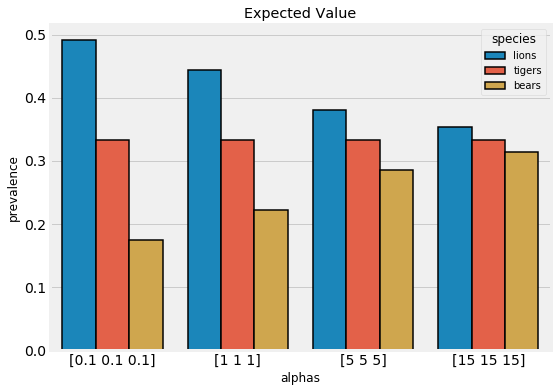

In [12]:
melted = pd.melt(value_df, id_vars = 'alphas', value_name='prevalence',
        var_name = 'species')

plt.figure(figsize = (8, 6))
sns.barplot(x = 'alphas', y = 'prevalence', hue = 'species', data = melted,
            edgecolor = 'k', linewidth = 1.5);
plt.xticks(size = 14); plt.yticks(size = 14)
plt.title('Expected Value');

# Maximum A Posterior Estimation

The maximum a posterior (MAP) is another point estimate that is equal to the mode of the posterior distribution. The MAP for a Dirichlet-Multinomial is:

$${\displaystyle \operatorname {arg\,max} \limits _{\mathbf {p} }p(\mathbf {p} \mid \mathbb {X} )={\frac {\alpha _{i}+c_{i}-1}{\sum _{i}(\alpha _{i}+c_{i}-1)}},\qquad \forall i\;\alpha _{i}+c_{i}>1}$$

In [13]:
dict(zip(animals, (alphas+c-1)/sum(alphas+c-1)))

{'lions': 0.5, 'tigers': 0.3333333333333333, 'bears': 0.16666666666666666}

In [14]:
values = []
for alpha_new in alpha_list:
    values.append((alpha_new + c - 1) / sum(alpha_new + c - 1))

value_df = pd.DataFrame(values, columns = animals)
value_df['alphas'] = [str(x) for x in alpha_list]
value_df

,lions,tigers,bears,alphas
0,0.636364,0.333333,0.030303,[0.1 0.1 0.1]
1,0.500000,0.333333,0.166667,[1 1 1]
2,0.388889,0.333333,0.277778,[5 5 5]
3,0.354167,0.333333,0.312500,[15 15 15]


In [17]:
melted = pd.melt(value_df, id_vars = 'alphas', value_name='prevalence',
        var_name = 'species')
melted


,alphas,species,prevalence
0,[0.1 0.1 0.1],lions,0.636364
1,[1 1 1],lions,0.500000
2,[5 5 5],lions,0.388889
3,[15 15 15],lions,0.354167
4,[0.1 0.1 0.1],tigers,0.333333
5,[1 1 1],tigers,0.333333
6,[5 5 5],tigers,0.333333
7,[15 15 15],tigers,0.333333
8,[0.1 0.1 0.1],bears,0.030303
9,[1 1 1],bears,0.166667


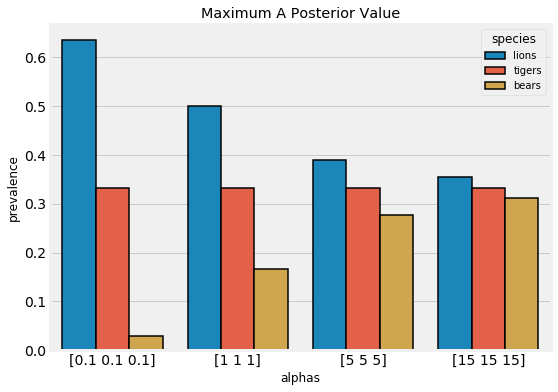

In [16]:
plt.figure(figsize = (8, 6))
sns.barplot(x = 'alphas', y = 'prevalence', hue = 'species', data = melted,
            edgecolor = 'k', linewidth = 1.5);
plt.xticks(size = 14); plt.yticks(size = 14)
plt.title('Maximum A Posterior Value');

# Bayesian Model

Now we'll get into building and sampling from a Bayesian model. As a reminder, we are using a multinomial as our model, a Dirichlet distribution as the prior, and a specified hyperparameter vector. The objective is to find the parameters of the multinomial, $p_k$ which are the probability of each species given the evidence.

$$(\mathbf {p} \mid \mathbb  {X}, {\boldsymbol {\alpha}})$$

# PyMC3 and MCMC

In [22]:
with pm.Model() as model:
    # Parameters of the Multinomial are from a Dirichlet
    parameters = pm.Dirichlet('parameters', a=alphas, shape =3)
    # Observed data is from a Multinomial distribution
    observed_data = pm.Multinomial('observed_data', n=6, p=parameters, shape =3, observed = c)

In [23]:
with model:
    # Sample from the posterior
    trace = pm.sample(draws=1000, chains=2, tune=500, 
                      discard_tuned_samples=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]
Sampling 2 chains, 0 divergences: 100%|█| 3000/3000 [00:34<00:00, 86.34draws/s] 


# Inspecting Results

PyMC3 offers comprehensive tools for inspecting the results of a trace. We can start by getting the stats in a dataframe.

In [25]:
summary = pm.summary(trace)
summary.index = animals
summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lions,0.450,0.158,0.158,0.732,0.004,0.003,1729.0,1689.0,1699.0,1110.0,1.0
tigers,0.332,0.156,0.077,0.622,0.004,0.003,1663.0,1543.0,1664.0,1390.0,1.0
bears,0.219,0.134,0.013,0.467,0.003,0.003,1616.0,1361.0,1725.0,1232.0,1.0


We can see that the mean of the samples is very close to the expected value. However, instead of just getting one number, we get a range of uncertainty as indicated by the large standard deviation and 95% highest probability interval.

In [27]:
# Samples
trace_df = pd.DataFrame(trace['parameters'], columns = animals)
trace_df.head()

,lions,tigers,bears
0,0.442906,0.223025,0.334069
1,0.317126,0.402301,0.280574
2,0.503855,0.134996,0.361149
3,0.462544,0.474124,0.063331
4,0.579687,0.357172,0.063142


In [29]:
trace_df.shape

(2000, 3)

For single point estiate we can use the mean of the samples

In [32]:
# For probabilities use samples after burn in
pvals = trace_df.iloc[:, :3].mean(axis = 0)
dict(zip(animals, pvals))

{'lions': 0.4498523325977999,
 'tigers': 0.3315962324897813,
 'bears': 0.21855143491241957}

These numbers align nearly exactly with the expected values! However, we also get a range of uncertainty.

In [33]:
summary.iloc[:, 3:5]

,hpd_97%,mcse_mean
lions,0.732,0.004
tigers,0.622,0.004
bears,0.467,0.003


We can see the large amount of uncertainty in the estimates due to the limited amount of data. To see the estimates and uncertainty visually, we can use some of PyMC3's built in plots.

# Diagnostic Plots

PyMC3 offers a number of plotting options for inspecting our samples.



## Posterior Plots

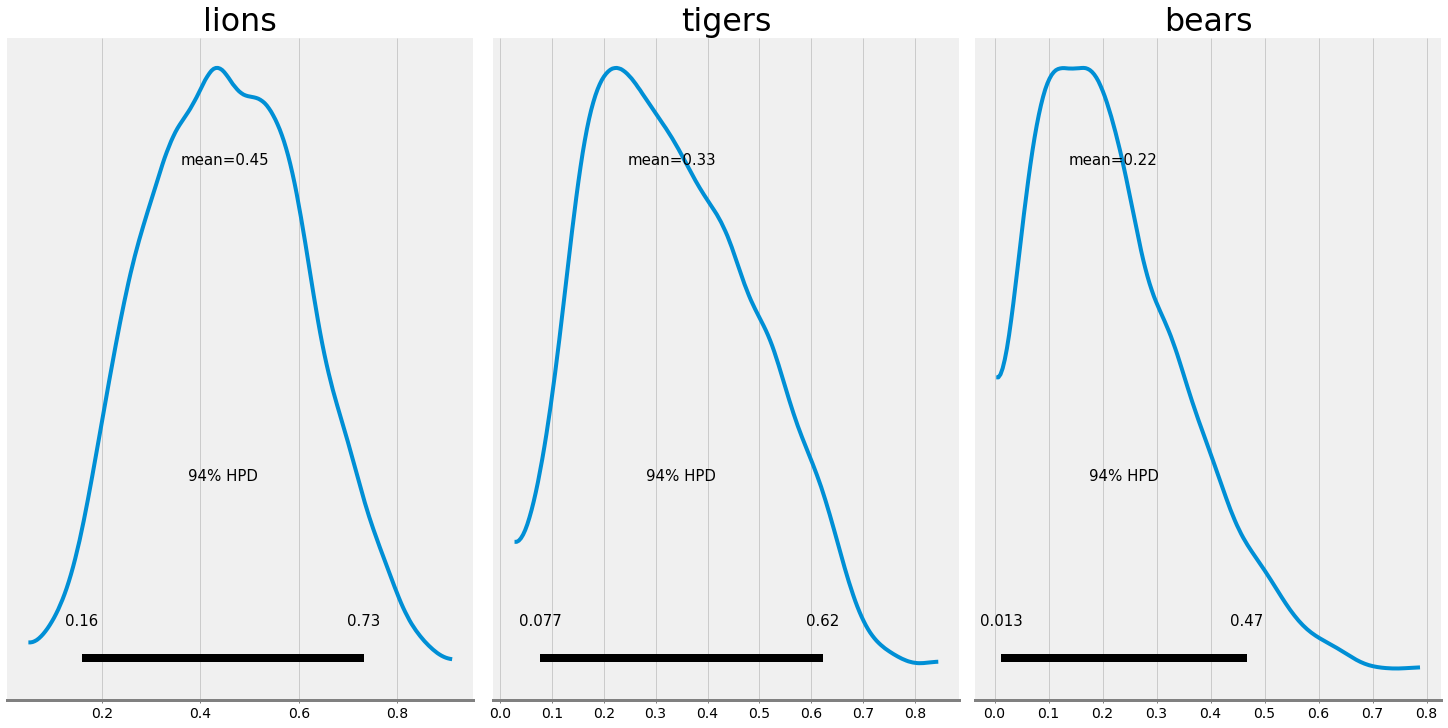

In [42]:
ax = pm.plot_posterior(trace, varnames = ['parameters'], 
                       figsize = (20, 10));

plt.rcParams['font.size'] = 22
for i, a in enumerate(animals):
    ax[i].set_title(a);

What we see hear is a histogram of the sampled values.

The 95% HPD is the same idea as a 95% confidence interval in frequentist statistics. In Bayesian stats, this is called the Highest Posterior Density.

# Traceplot

The traceplot shows a kernel density estimate (a smoothed histogram) on the left and all the samples that were drawn on the right. We collapse the chains on th plots (combined = True) but in reality we drew 2 independent chains.

C:\Users\adhar\Anaconda3\lib\site-packages\pymc3\plots\__init__.py:21: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))
C:\Users\adhar\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


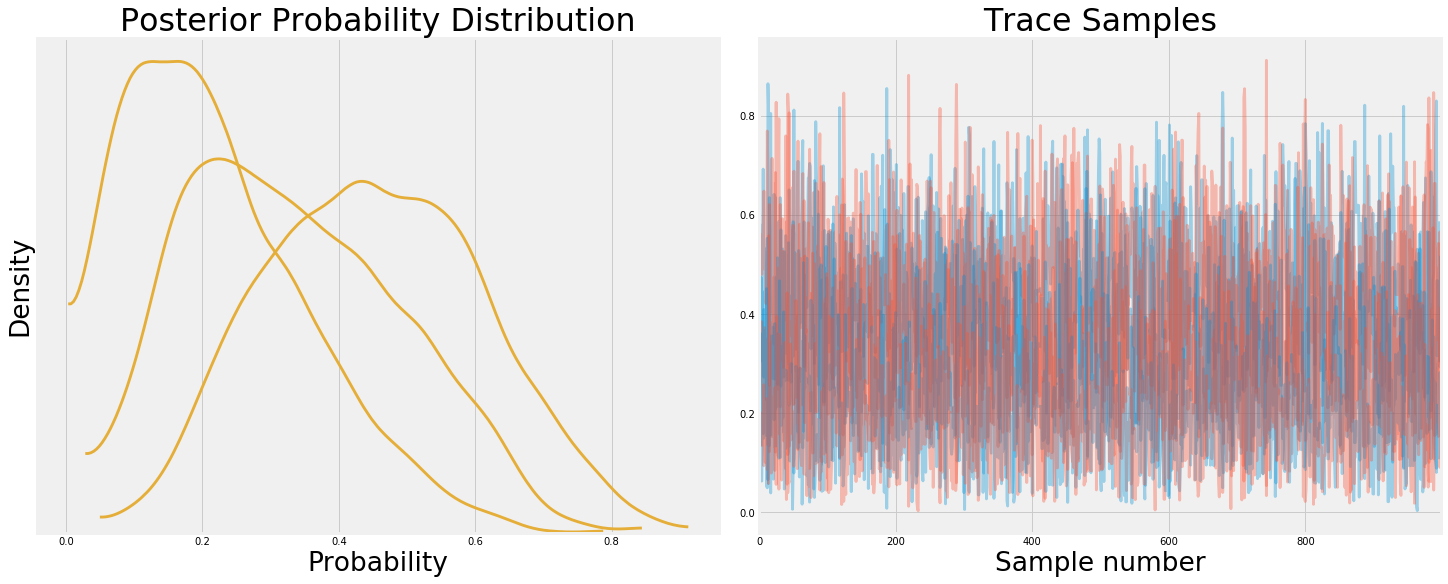

In [46]:
prop_cycle = plt.rcParams['axes.prop_cycle']
cs = [x['color'] for x in list(prop_cycle)]

ax = pm.traceplot(trace, varnames = ['parameters'], figsize = (20, 8), combined = True);
ax[0][0].set_title('Posterior Probability Distribution'); ax[0][1].set_title('Trace Samples');
ax[0][0].set_xlabel('Probability'); ax[0][0].set_ylabel('Density');
ax[0][1].set_xlabel('Sample number');
# add_legend(ax[0][0])
# add_legend(ax[0][1])

Even here we see a large amount of uncertainty although the model is clear that $p_{bears} &lt ; p_{tigers} &lt ; p_{lions}$.

# Increasing/Decreasing Confidence in Hyperparameters

As noted earlier, we can increase or decrease our confidence in our initial belief by changing the weighting of the hyperparameter vector. Initially we use all 1s, but we can reduce or increase this.

In [48]:
animals = ['lions', 'tigers', 'bears']
c = np.array([3, 2, 1])

def sample_with_priors(alphas):
    """Sample with specified hyperparameters"""
    with pm.Model() as model:
        # Probabilities for each species
        parameters = pm.Dirichlet('parameters', a=alphas, shape=3)
        # Observed data is a multinomial distribution with 6 trials
        observed_data = pm.Multinomial(
            'observed_data', n=6, p=parameters, shape=3, observed=c)    

        trace = pm.sample(draws=1000, chains=2, tune=500, discard_tuned_samples=True)
    return trace

In [49]:
trace_dict = {}
for alpha_array in [np.array([0.1, 0.1, 0.1]), np.array([1, 1, 1]),
                    np.array([5, 5, 5]), np.array([15, 15, 15])]:
    trace_dict[str(alpha_array[0])] = sample_with_priors(alpha_array)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]
Sampling 2 chains, 0 divergences: 100%|█| 3000/3000 [00:13<00:00, 228.48draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]
Sampling 2 chains, 0 divergences: 100%|█| 3000/3000 [00:15<00:00, 193.02draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]
Sampling 2 chains, 0 divergences: 100%|█| 3000/3000 [00:18<00:00, 165.29draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [parameters]
Sampling 2 chains, 0 divergences: 100%|█| 3000/3000 [00:18<00:00, 165.80draws/s]


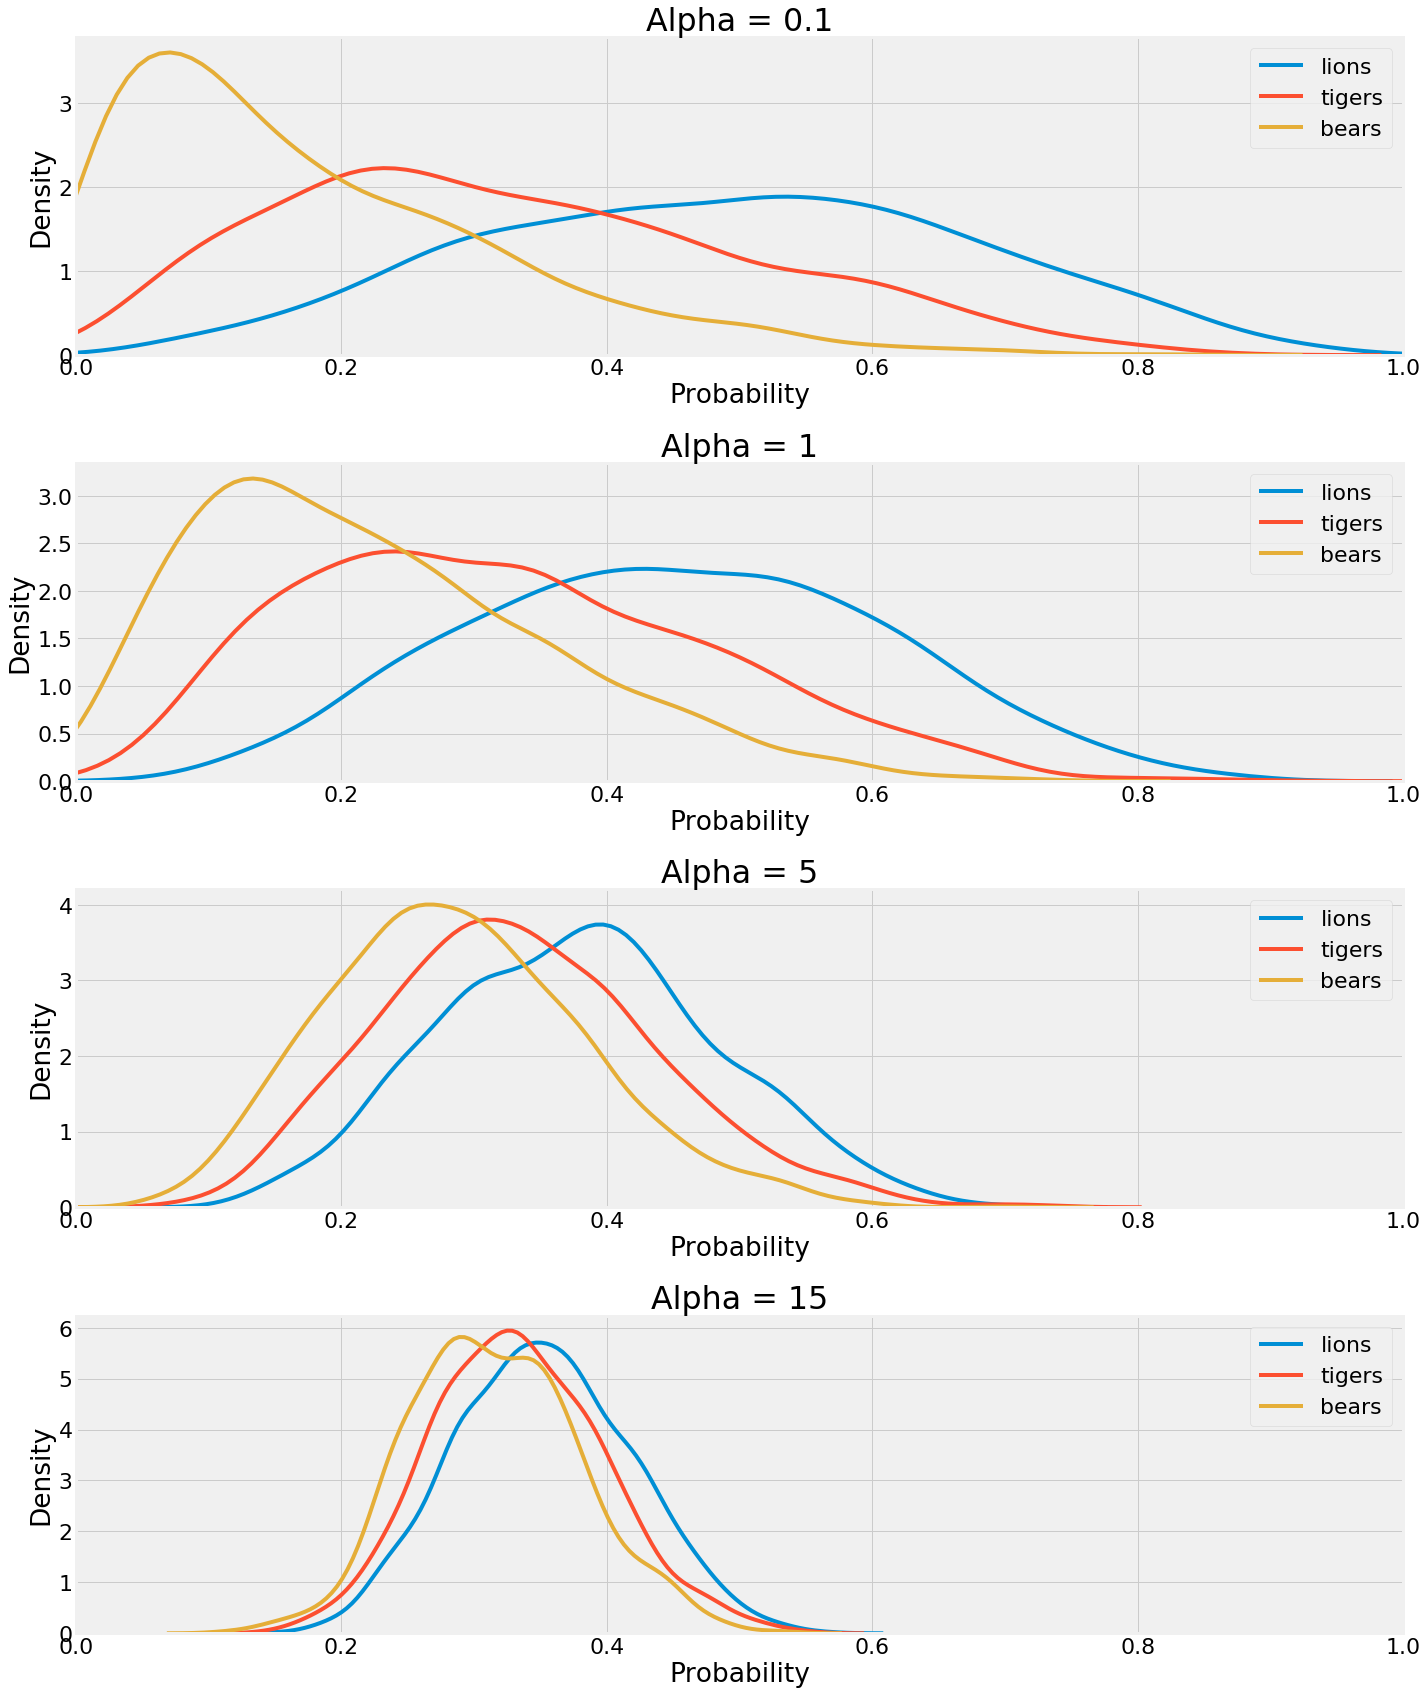

In [50]:

plt.figure(figsize = (20, 24))

for ii, (alpha, trace) in enumerate(trace_dict.items()):
    plt.subplot(4, 1, ii + 1)
    array = trace['parameters']
    for jj, animal in enumerate(animals):
        sns.kdeplot(array[:, jj], label = f'{animal}')
    plt.legend();
    plt.xlabel('Probability'); plt.ylabel('Density')
    plt.title(f'Alpha = {alpha}');
    plt.xlim((0, 1));
    
plt.tight_layout();
plt.show();

As the weight increases, the estimated prevalence tends to collapse to 1/3 for each species. These results are intuitive: if we have a greater belief that the prevalences are equivalent, then the limited data we collected should not change our beliefs greatly.